# Binary Classification Competition: Software Defects Dataset

# Table of contents
1. [Introduction](#introduction)
    1. [The Task](#thetask)
    2. [The Data](#thedata)
    3. [Key Contributions](#keycontribs)
2. [Preliminaries](#prelims)
    1. [Import libraries](#imports)
    2. [Importing the data](#importdata)
3. [Defining helper functions](#helpers)
4. [Training a baseline model](#base)
5. [Exploratory data analysis](#eda)
6. [Creating transformation pipelines](#pipe)
5. [Testing models](#model)
    1. [Random forest on prepared data, polynomial data, and oversampled data](#m1)
    2. [Regularised random forest](#m2)
    3. [Extra-tree classifier](#m3)
    4. [Logistic Regression](#m4)
    5. [Histogram-based gradient boosted forest](#m5)
   6. [Gradient boosted classifier](#m6)
6. [Final Ensembles](#ensemble)


## Introduction <a name="introduction"></a>

### The Task<a name="thetask"></a>

In this Kaggle competition, we aim to use a software defect dataset to predict the probability that software will have a defect in it. The competition will be evaluated using the area under the ROC curve.
- competition available [here](https://www.kaggle.com/competitions/playground-series-s3e23/overview)
- feature descriptions available [here](https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction)

### About the data<a name="thedata"></a>

- this artificially generated dataset consists of 23 numerical features, including the binary variable 'defects' that we aim to predict.
- the dataset is imbalanced, with only about 20% of data points having defects
- most of of features are weakly correlated to the feature we are trying to predict, but are highly correlated with one another
- the winning Kaggle notebook achieved an roc-auc score of approximately 0.78. 

### Key contributions and findings<a name="keycontribs"></a>

- This notebook defines several helper functions that can be generalised and used for other classification tasks. They allow us to:
    - easily compare models trained on the original training data with models trained on an oversampled training set (i.e. a dataset that has oversampled the minority class to obtain an equal proportion of both classes)
    - plot the roc-auc graphs of multiple models 
    - track the performance of models using a dataframe
    - tune the hyperparameters of models easily
- The two most important features for predicting if software will have a defect were created by our own feature engineering. 
    - The first, called 'length', is equal to the ratio of a program's line count divided by the estimated length of the program based on the number of operands in the software. A small value for this ratio indicates that software contains many operands relative to the number of lines of code.
    - The second feature we found to be of importants was the proportion of unique operators relative to the total number of operators used in the software. Low values for this ratio are correlated with defective data, since a low value of this ratio indicates that the same operands are used repeatedly in the software.
- The singal in this data appears to be relatively weak. Even quite advanced techniques do not icrease the roc-auc validation score dramatically when compare to a simple regularised random forest. To improve the final score in this notebook, we believe the two best avenues for further work would be (1) more advanced feature engineering, and (2) finer hyper-parameter tuning (which could be achieved here with limitted computation power).



# Preliminaries <a name="prelims"></a>

## Import libraries<a name="imports"></a>

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns
import numpy as np
import os
import pickle

from sklearn.cluster import KMeans
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
    cross_val_predict,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_predict,
)
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    StackingClassifier,
    VotingClassifier,
    GradientBoostingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer, KNNImputer

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from xgboost import XGBClassifier

import warnings

warnings.simplefilter("ignore")

## Importing the data<a name="importdata"></a>

In [84]:
file_path_train = "/Users/kim/Documents/software_defects_competition/train.csv"
file_path_test = "/Users/kim/Documents/software_defects_competition/test.csv"

train_df = pd.read_csv(file_path_train)
test_df = pd.read_csv(file_path_test)

print(
    f"Our training dataframe has {train_df.shape[0]} rows and {train_df.shape[1]} features."
)
print(
    f"Our testingdataframe has {test_df.shape[0]} rows and {test_df.shape[1]} features."
)

Our training dataframe has 101763 rows and 23 features.
Our testingdataframe has 67842 rows and 22 features.


In [4]:
train_df.drop(columns=["id"], inplace=True)
train_df.drop_duplicates(inplace=True)
train_df["defects"] = train_df["defects"].astype(int)

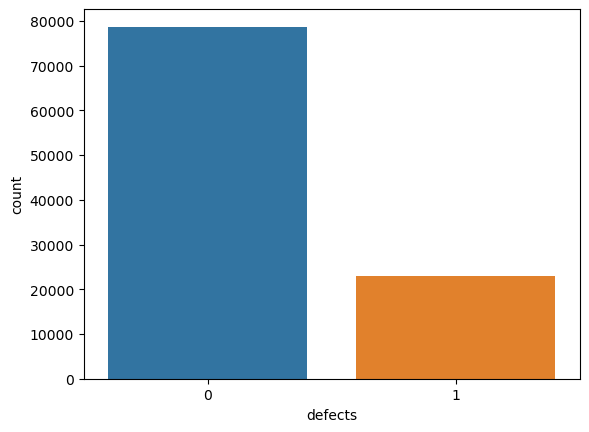

In [5]:
ax = sns.countplot(x="defects", data=train_df)

This is an imabalanced classification task.

# Defining helper functions<a name="helpers"></a>

Here we define several helper functions. 

The train_classifier() function calculates the training and valiation auc scores for a given model and saves them to a .pickle file, along with the confusion matrix of the model calculated on validation folds of the dataset. When oversampling = True the training folds are oversampled using imblearns SMOTE() oversampling method, to obtain a training set which has an equal proportion of positive and negative classes. 

In [6]:
def train_classifier(model, model_name, X, y, cv=3, oversampling=False):
    """Calculate the roc_auc score on validation folds using StatifiedKFold cross validation. Saves the training and validation
     roc scores, along with the normalized confusion matrix, to a dictionary.
    
    Parameters
    ----------
    model: Sklearn classifier
    model_name: str 
    X: np.ndarray
        input data
    y: np.ndarray
        output variable
    cv: int (default = 3)
        number of folds for cross-validation
    oversampling: Bool (default = False)
        True to oversampling the training folds to obtain balanced training data sets
        False for no oversampling 

    Saved Files 
    ------
    Saved file path: "saved_objects/{model_name}_scores.pickle" if oversampling = False
                     "saved_objects/{model_name}_oversampled_scores.pickle" if oversampling = True
    Saves the dictionary with keys {auc_train, auc_test, true_neg, false_pos, false_neg, true_pos} where
    auc_train, auc_test are the roc-auc scores for the training and validation sets, respectively. The keys
    are the percentage of negative/positive classes whose prediction was true/false (eg. false_neg
    is the percentage of points in the negative class that were incorrectly predicted to be positive). 
    
    Returns
    ------
    roc-auc plot if plot_roc_curve = True else no return 
    """
        
    folds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    y_test_vals = []
    y_train_vals = []
    test_probs = []
    train_probs = []
    predictions = []
    
    for train_index, test_index in folds.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[test_index], y[test_index]

        if oversampling:
            over_sampler = SMOTE(random_state=42)
            X_train_oversample, y_train_oversample = over_sampler.fit_resample(
                X_train, y_train
            )
            model.fit(X_train_oversample, y_train_oversample)
        else:
            model.fit(X_train, y_train)

        fold_train_predictions = model.predict_proba(X_train)[:, 1]
        fold_test_predictions = model.predict_proba(X_val)[:, 1]
        predictions.extend(model.predict(X_val))

        y_test_vals.extend(y_val)
        y_train_vals.extend(y_train)

        train_probs.extend(fold_train_predictions)
        test_probs.extend(fold_test_predictions)

    auc_train = round(roc_auc_score(y_train_vals, train_probs), 5)
    auc_test = round(roc_auc_score(y_test_vals, test_probs), 5)

    tn, fp, fn, tp = confusion_matrix(
        y_test_vals, predictions, normalize="true"
    ).ravel()
    tn, fp, fn, tp = (
        round(tn * 100, 2),
        round(fp * 100, 2),
        round(fn * 100, 2),
        round(tp * 100, 2),
    )

    scores = {
        "auc_train": auc_train,
        "auc_test": auc_test,
        "true_neg": tn,
        "false_pos": fp,
        "false_neg": fn,
        "true_pos": tp,
    }

    scores_path = f"saved_objects/{model_name}_scores.pickle"
    predictions_path = f"saved_objects/{model_name}_predictions.pickle"
    
    saved_predictions = [y_test_vals, test_probs]
    
    pickle.dump(scores, open(scores_path, "wb"))

    pickle.dump(saved_predictions, open(predictions_path, "wb"))


In [85]:
def plot_roc_curve(model_names):
    """Plot the roc_auc curve of one or more models.
    
    Parameters
    ----------
    model_names: list(str)
        list of model names that have been used with the train_classifier() function

    Saved Files 
    ------
    None
    
    Returns
    ------
    roc-auc plot
    """
    roc_curve_data = []
    for model in model_names:
        predictions_path = f"saved_objects/{model}_predictions.pickle"
        predictions = pickle.load(open(predictions_path, "rb"))
        roc_curve_data.append(predictions + [model])

    plt.figure(figsize=(6, 5))
    n = len(model_names)
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))

    for y, preds, model_name in roc_curve_data:
        c = next(color)
        fpr, tpr, thresholds = roc_curve(y, preds)
        plt.plot(fpr, tpr, linewidth = 2, c = c, label = model_name)

    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid()
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="lower right")
    plt.title("ROC-AUC curve")
    plt.show()

The update_results() function uses the scores obtain from the train_classifier function and adds these scores as a row in a dataframe. This allows us to easily compare many models. Throughout this notebook, results_df will be a dataframe that will be updated using update_results.

In [8]:
def update_results(df, model_name, include_oversampled=True):
    """Appends the scores calculated from train_classifier() to a given dataframe. If a row in the dataframe df already 
     has df.model = model_name, this row will be over-written.
    
    Dependencies
    ----------
    train_classifier() must be run before this function to create appropriate saved files
    
    Parameters
    ----------
    df: pd.DataFrame with columns {model, training_auc, testing_auc, true_neg, false_pos, false_neg, true_pos}
    model_name: str 
    include_oversampled: Bool (default = True)
        True to append df with the model's scores and the oversampled model's scores 
        False to append only the model's scores (with no oversampling)

    Saved Files 
    ------
    None    
    
    Returns
    ------
    Dataframe df, sorted by testing_auc, with the model's scores appended 
    """
    path_name = f"saved_objects/{model_name}_scores.pickle"

    saved_scores = pickle.load(open(path_name, "rb"))

    if model_name in df.model.values:
        df = df[df.model != model_name]

    df = df.append(
        {
            "model": f"{model_name}",
            "training_auc": saved_scores["auc_train"],
            "testing_auc": saved_scores["auc_test"],
            "true_neg": saved_scores["true_neg"],
            "false_pos": saved_scores["false_pos"],
            "false_neg": saved_scores["false_neg"],
            "true_pos": saved_scores["true_pos"],
        },
        ignore_index=True,
    )
    if include_oversampled:
        path_name_over = f"saved_objects/{model_name}_oversampled_scores.pickle"
        
        saved_scores_over = pickle.load(open(path_name_over, "rb"))
        
        if f"{model_name}_oversampled" in df.model.values:
            df = df[df.model != f"{model_name}_oversampled"]
            
        df = df.append(
            {
                "model": f"{model_name}_oversampled",
                "training_auc": saved_scores_over["auc_train"],
                "testing_auc": saved_scores_over["auc_test"],
                "true_neg": saved_scores_over["true_neg"],
                "false_pos": saved_scores_over["false_pos"],
                "false_neg": saved_scores_over["false_neg"],
                "true_pos": saved_scores_over["true_pos"],
            },
            ignore_index=True,
        )

    df.sort_values(by="testing_auc", ascending=False, inplace=True)
    return df

The get_params() function will use randomized search cross validation to find the best choice of parameters (given through the variable 'params')
for a given model. These parameters will be calculated for both the model trained on X as well as the model trained on an oversampled
version of X. The best parameters will then be returned as a dictionary and saved as a pickle file for future reference.

In [15]:
def get_params(model_name, input_data, output_data, model=None, params=None, n_iter=20, cv=3, include_oversampled = True, verbose = 0):
    """Uses randomized search cross validation to find the most optimal parameters for the given model out of 
    a given list of parameters called params. When include_oversampled = True optimal parameters will also be found
    for the model with oversampling.
    
    Parameters
    ----------
    model_name: str
    model: Sklearn model (optional if the file "saved_objects/{model_name}_{n_iter}_{cv}.pickle" exists)
    params: list
        The dictionary of parameters contained in a list, eg. [{
        "max_depth": 10,
        "max_features":  5}]
    n_iter: int (default = 20)
        The number of iterations used by randomized search cross validation
    cv: int (default = 3)
        The number of folds used by randomized search cross validation
    include_oversampled: Bool (default = True)
        True to find optimal parameters for the oversampled version of the model and the original model, separately
        False to find optimal parameters for the original model only
    verbose: int (default = 0)
        5 to print calculation updates during running randomized search cv
        0 otherwise

    Saved Files 
    ------
    Saved file path: "saved_objects/{model_name}_{n_iter}_{cv}.pickle"
    Saves the dictionary with keys {best_params, best_oversampled_params} if include_oversampled = True, values of dictionary
    are themselves dictionaries with the best parameters found for the original model and oversampled model, respectively.
    If include_oversampled = False saves dictionary with key {best_params}.
    
    Returns
    ------
    If include_oversampled = True, return dictionary with keys {best_params, best_oversampled_params}.
    If include_oversampled = False, returns dictionary with key {best_params}.
    """
    path_name = f"saved_objects/{model_name}_{n_iter}_{cv}.pickle"
    best_params_already_found = False
    param_dict = {}
    if os.path.isfile(path_name):
        saved_params = pickle.load(open(path_name, "rb"))
        param_dict["best_params"] = saved_params[0]
        
        if (len(saved_params) == 1 and not include_oversampled) or (len(saved_params)==2 and not include_oversampled): 
            return param_dict
        elif (len(saved_params)==2 and include_oversampled):
            param_dict["best_oversampled_params"] = saved_params[1]
            return param_dict
        else:
            best_params_already_found= True 
            
    if not best_params_already_found:        
        rnd_search = RandomizedSearchCV(
            model,
            param_distributions=params,
            n_iter=n_iter,
            cv=cv,
            scoring="roc_auc",
            random_state=42,
            verbose=verbose,
        )
        rnd_search.fit(input_data, output_data)

        best_parameters = rnd_search.best_params_
        saved_params = [best_parameters]
        param_dict = {
            "best_params": saved_params[0]
        }

    if include_oversampled:
        oversampled_model = oversampled_version(model, model_name)

        oversampled_params = {
            f"oversampled_{model_name}__{key}": val
            for key, val in zip(params[0].keys(), params[0].values())
        }

        rnd_search_oversampled = RandomizedSearchCV(
            oversampled_model,
            param_distributions=oversampled_params,
            n_iter=n_iter,
            cv=cv,
            scoring="roc_auc",
            random_state=42,
            verbose=verbose,
        )
        rnd_search_oversampled.fit(input_data, output_data)

        best_parameters_over = rnd_search_oversampled.best_params_

        oversampled_keys = []
        for key in best_parameters_over.keys():
            oversampled_keys.append(key.split("__")[1])

        best_parameters_over = {
            k: v for k, v in zip(oversampled_keys, best_parameters_over.values())
        }
        saved_params.append(best_parameters_over)
        param_dict["best_oversampled_params"] = best_parameters_over

    pickle.dump(saved_params, open(path_name, "wb"))

    return param_dict

The train_best_clf() trains a given model using the best parameters for that model calculated from get_params(). It also trains the model on the oversampled training data, again with parameters calculated from the get_params() function. 

In [17]:
def train_best_clf(model, model_name, params, input_data, output_data, n_iter=20, cv=3, include_oversampled = True):
    """Calls train_classifier to train the model for the best choice of parameters out of params found using
    the function get_params. When include_oversampled = True, repeats this for the oversampled model as well.
    
    Parameters
    ----------
    model: Sklearn model 
    model_name: str
    X: np.ndarray
        input data
    y: np.ndarray
        output variable
    params: list
        The dictionary of parameters contained in a list, eg. [{
        "max_depth": 10,
        "max_features":  5}]
    n_iter: int (default = 20)
        The number of iterations used by randomized search cross validation when get_params() is called
    cv: int (default = 3)
        The number of folds used by randomized search cross validation when get_params() is called
    include_oversampled: Bool (default = True)
        True to train the oversampled version of the model and the original model with their optimal parameters
        False to train the original model with its optimal parameters

    Saved Files 
    ------
    Same as those from get_params() and train_classifier() 
    
    Returns
    ------
    If include_oversampled = True, return dictionary with keys {best_params, best_oversampled_params}.
    If include_oversampled = False, returns dictionary with key {best_params}.
    """
    best_params = get_params(input_data = input_data, output_data =output_data,
        model=model, model_name=model_name, params=params, n_iter=n_iter, cv=cv, include_oversampled = include_oversampled
    )

    best_model = model.set_params(**best_params["best_params"]) 
    train_classifier(best_model, model_name, input_data,output_data )
    
    if include_oversampled:
        best_model_oversampling = model.set_params(
            **best_params["best_oversampled_params"] 
        )

        train_classifier(
            best_model_oversampling, f"{model_name}_oversampled", input_data, output_data, oversampling=True
        )

Finally, it will be convienant to define the following function oversampled_version(), which returns a given model with an additional oversampling step.

In [18]:
def oversampled_version(model, model_name):
    return imbpipeline([("sample", SMOTE()), (f"oversampled_{model_name}", model)])

# Training a baseline model <a name="base"></a>
Here we train a basic random forest classifier. This will allow us to compare later models to a very basic model. 

In [19]:
results_df = pd.DataFrame(
    columns=[
        "model",
        "training_auc",
        "testing_auc",
        "true_neg",
        "false_pos",
        "false_neg",
        "true_pos",
    ]
)

In [20]:
forest = RandomForestClassifier(random_state=42)

X_train, y_train = train_df.drop(columns="defects").to_numpy(), train_df["defects"]

train_classifier(forest, "baseline_forest", X_train, y_train)

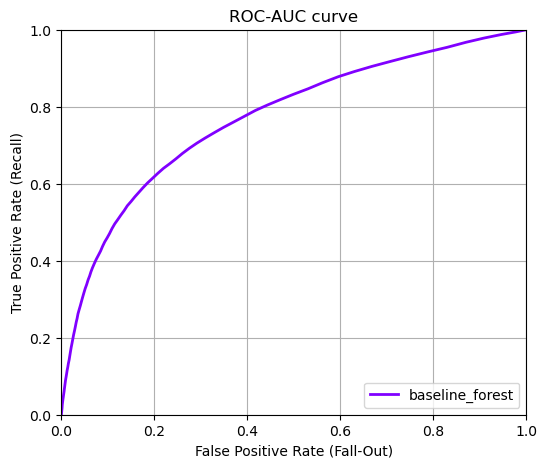

In [21]:
plot_roc_curve(['baseline_forest'])

In [23]:
results_df = update_results(results_df, "baseline_forest", include_oversampled = False)
results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,baseline_forest,1.0,0.77006,93.66,6.34,62.92,37.08


Our random forest appears to be severely overfitting the training data. It can predict the predominant class well but not the minority class (i.e. when defects occur). Ineed, close to 63% of the defective class was classified incorrectly.

# Exploratory Data Analysis <a name="eda"></a>

In this section we 
- create new features
    - the propn_uniq_op feature represents the proportion of unique operators relative to the total number of operators
    - the propn_uniq_opnd feature represents the proportion of unique operands relative to the total number of operands
    - the length feature represents Halstead's program length divided by the line count of code
    - zero_vals will be an indicator variable that equals one if the train_df.n is equal to zero. This is a proxy for data points that have many features equal to zero, since when the feature n equals zero, many of the other features tend to also equal zero. 
    
- apply a power scaling to our data*
- look at histograms of the data
- drop redundant highly correlated variables  

*We apply a power scaling since the original data is heavily skewed. 

In [24]:
train_df["propn_uniq_op"] = train_df["uniq_Op"] / (train_df["total_Op"] + 1)

train_df["propn_uniq_opnd"] = train_df["uniq_Opnd"] / (train_df["total_Opnd"] + 1)

train_df["length"] = train_df["l"] / (train_df["loc"] + 1)

train_df["zero_vals"] = train_df.n.apply(lambda x: 1 if x == 0 else 0)

In [25]:
power_transform = PowerTransformer()
prepared_df = train_df.drop(columns=["defects"])
fitted_cols = power_transform.fit_transform(prepared_df.to_numpy())

prepared_df = pd.DataFrame(fitted_cols, columns=list(prepared_df.columns))
prepared_df["defects"] = train_df["defects"]

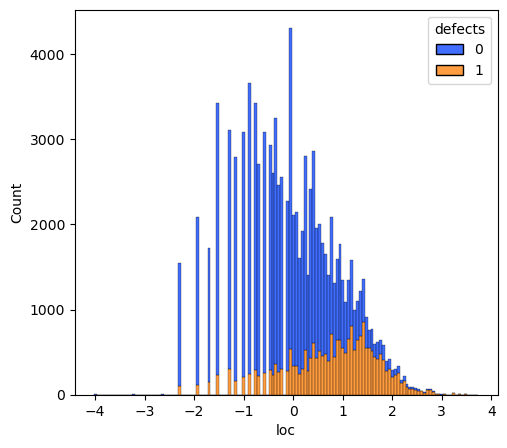

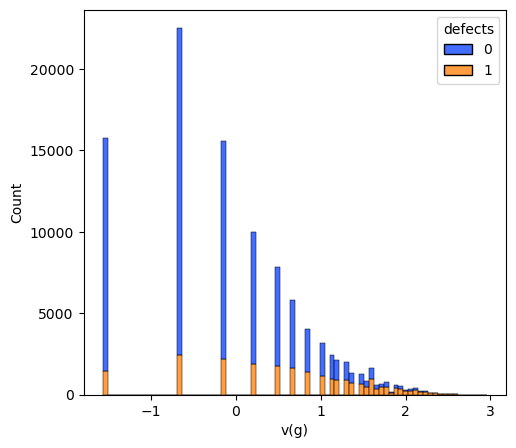

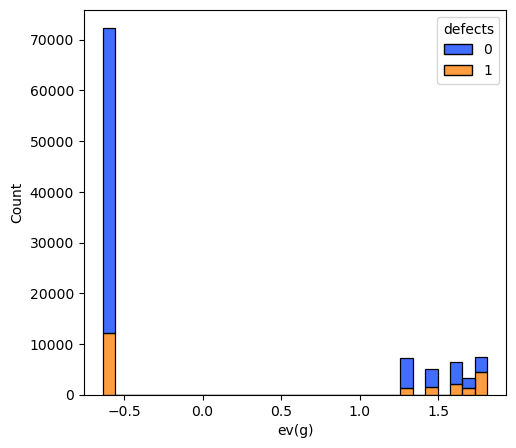

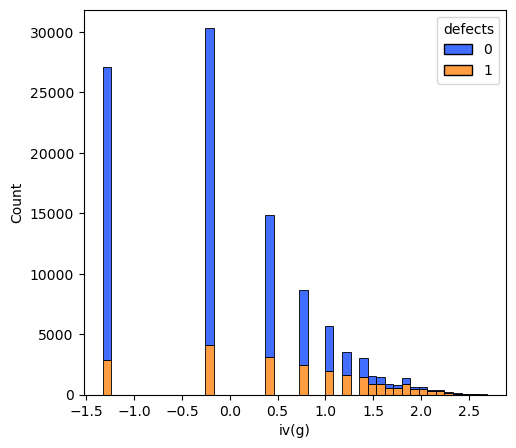

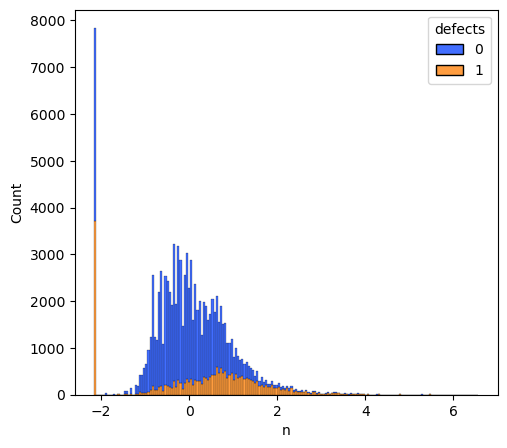

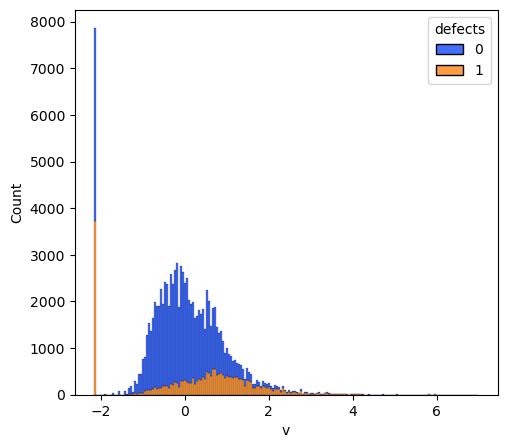

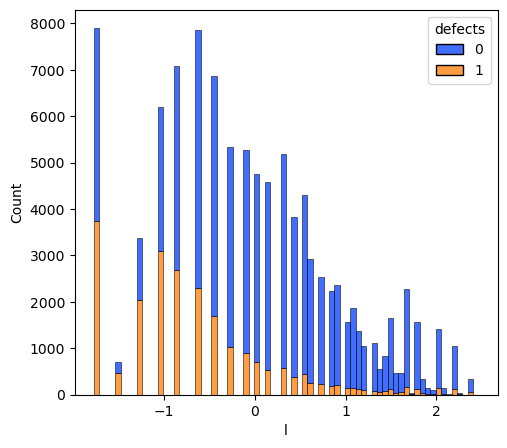

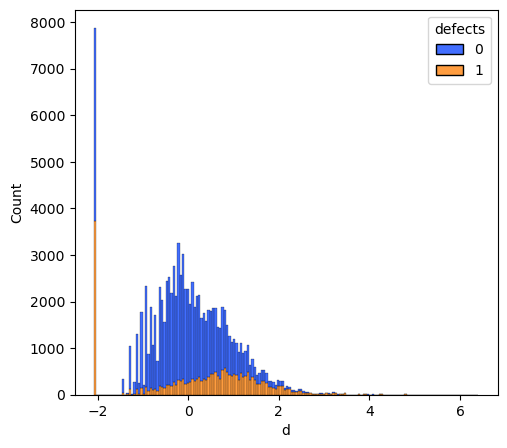

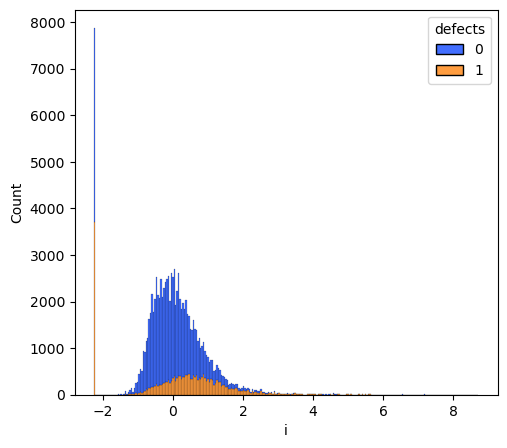

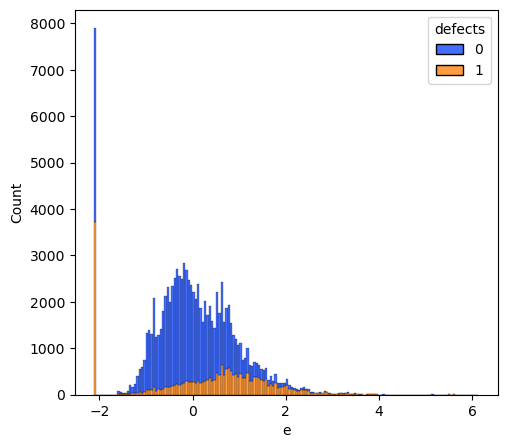

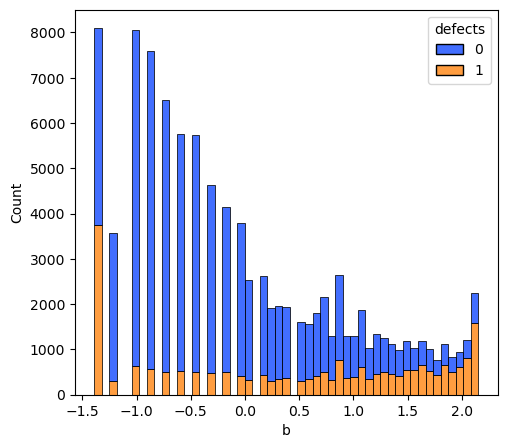

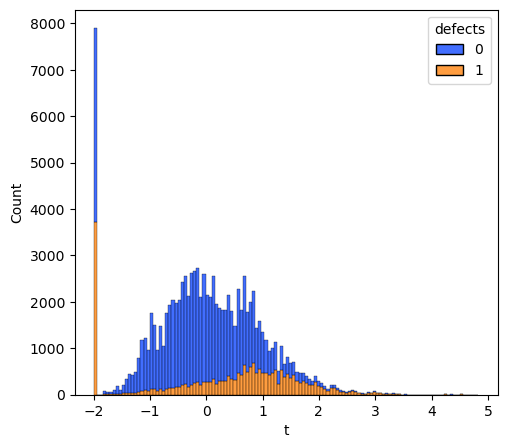

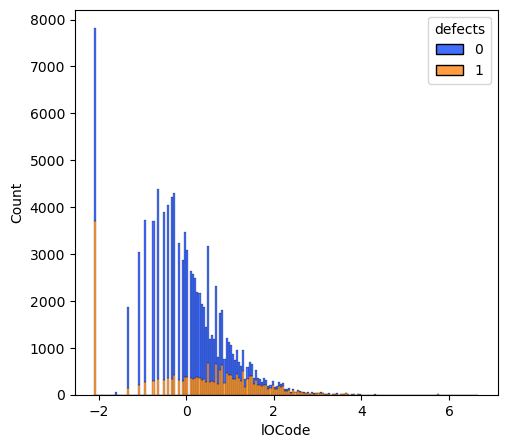

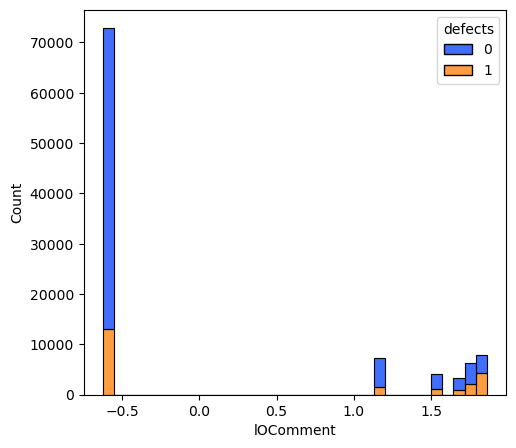

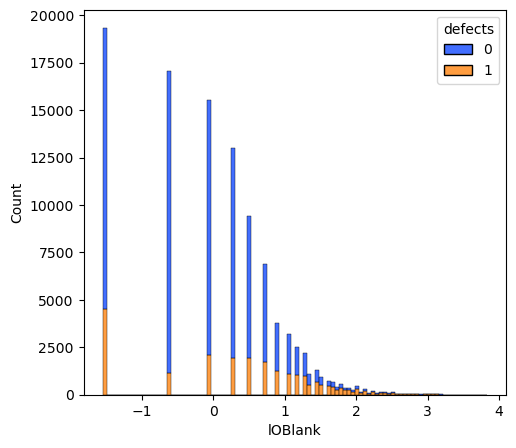

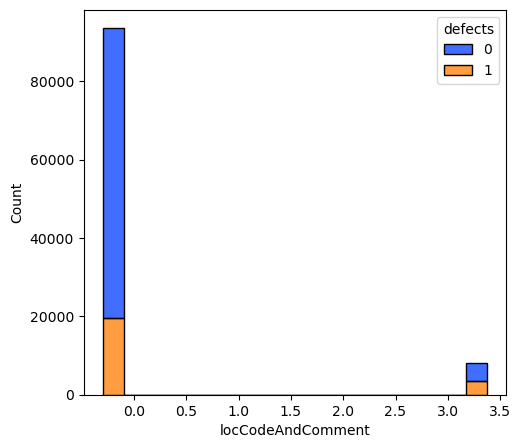

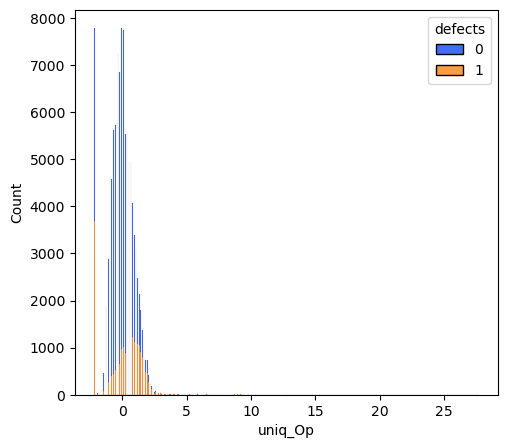

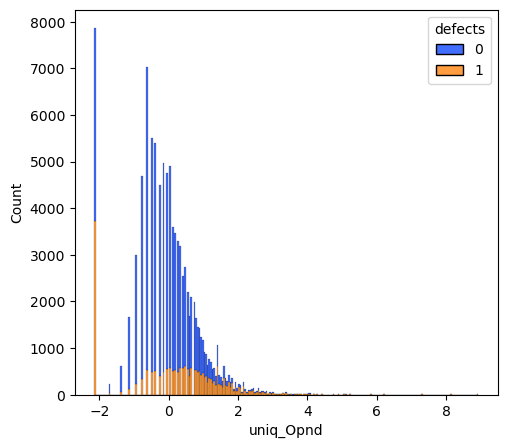

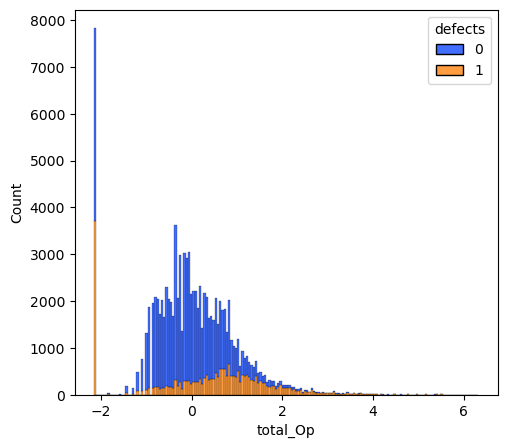

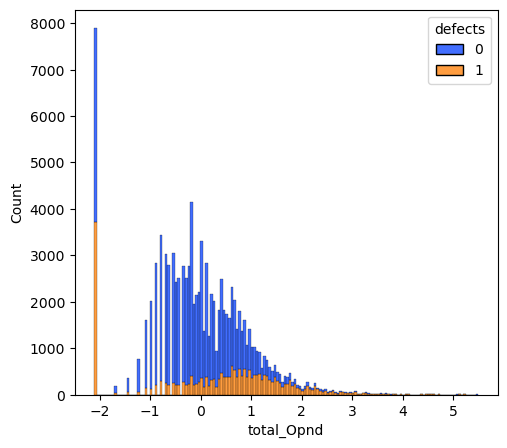

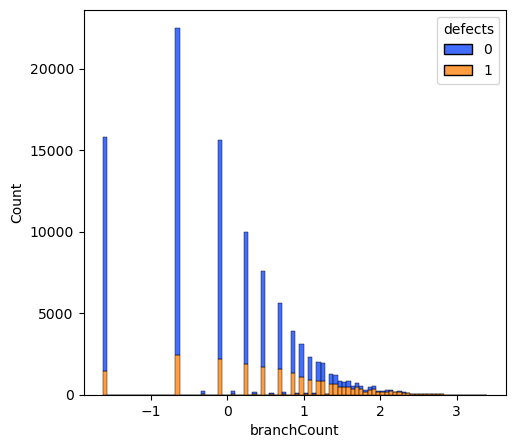

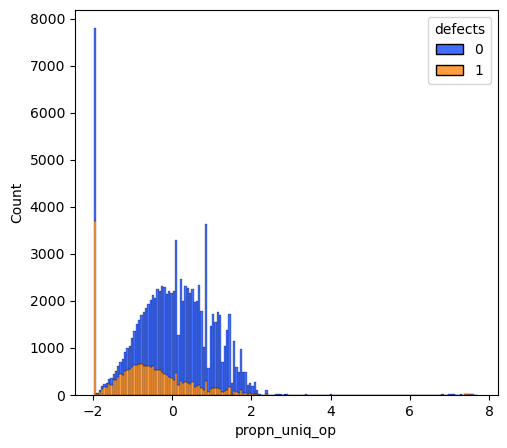

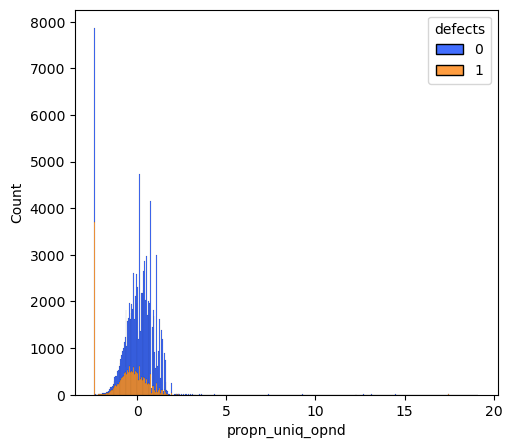

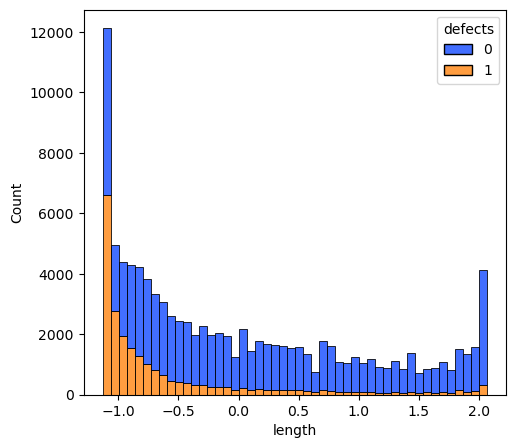

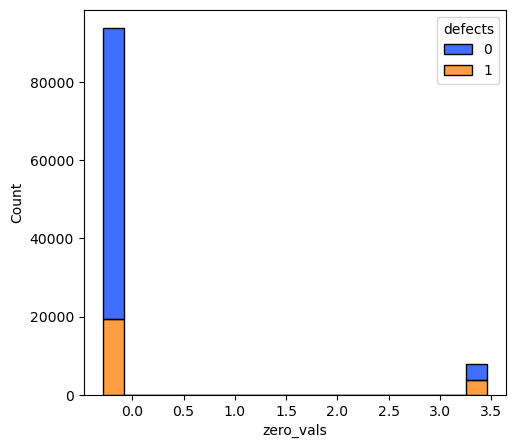

In [26]:
for col in prepared_df.drop(columns=["defects"]).columns:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(
        data=prepared_df, x=col, hue="defects", multiple="stack", palette="bright"
    )

The variables created from the feature engineering step look promising, since on average the values for defected and non-defected code are dissimilar. 

It appears that, on average, the more lines of code, the more likely it is the code will have a defect. 

The complexity, v(g), also seems to be a good indicator of if a defect is present.

Finally, we look for highly correlated variables with the 'defects' column.

In [27]:
corr_matrix = prepared_df.corr().apply(lambda x: abs(x))
corr_matrix["defects"].sort_values(ascending=False)

defects              1.000000
loc                  0.414630
v(g)                 0.351820
propn_uniq_op        0.351574
branchCount          0.348739
iv(g)                0.338630
l                    0.332410
length               0.324535
propn_uniq_opnd      0.284395
b                    0.269164
ev(g)                0.232630
lOBlank              0.217061
lOComment            0.197029
lOCode               0.190262
t                    0.187754
total_Opnd           0.182955
v                    0.181143
n                    0.180616
total_Op             0.180389
e                    0.178265
uniq_Opnd            0.173605
zero_vals            0.170835
d                    0.155556
uniq_Op              0.137894
locCodeAndComment    0.136039
i                    0.128258
Name: defects, dtype: float64

Most of our variables are weakly correlated with defects. The variables we created are fairly well correlated to defects in comparison to most of the original variables. We now drop variables that are highly correlated with other variables in the feature set, to remove redundancy. 

In [28]:
drop_cols = [
    "n",
    "v",
    "d",
    "i",
    "b",
    "t",
    "lOCode",
    "v(g)",
    "l",
    "e",
    "uniq_Op",
    "loc",
    "lOBlank",
    "total_Op",
    "uniq_Opnd",
]

<Axes: >

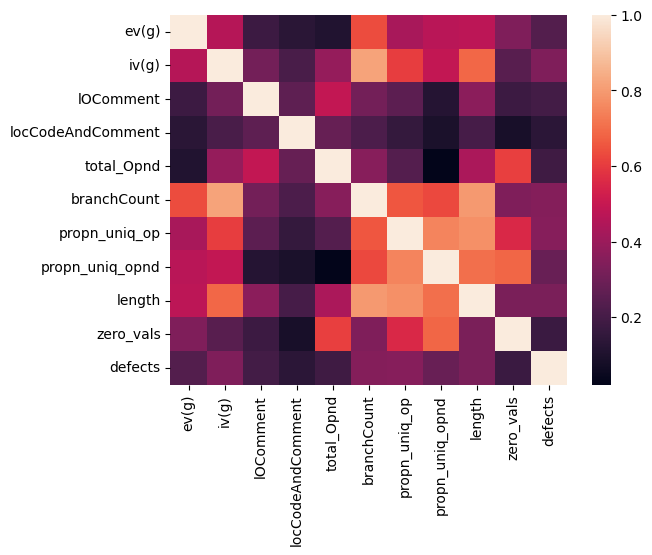

In [29]:
corr_matrix = prepared_df.drop(columns=drop_cols).corr().apply(lambda x: abs(x))
sns.heatmap(corr_matrix)

In [30]:
prepared_df.drop(columns=drop_cols, inplace=True)

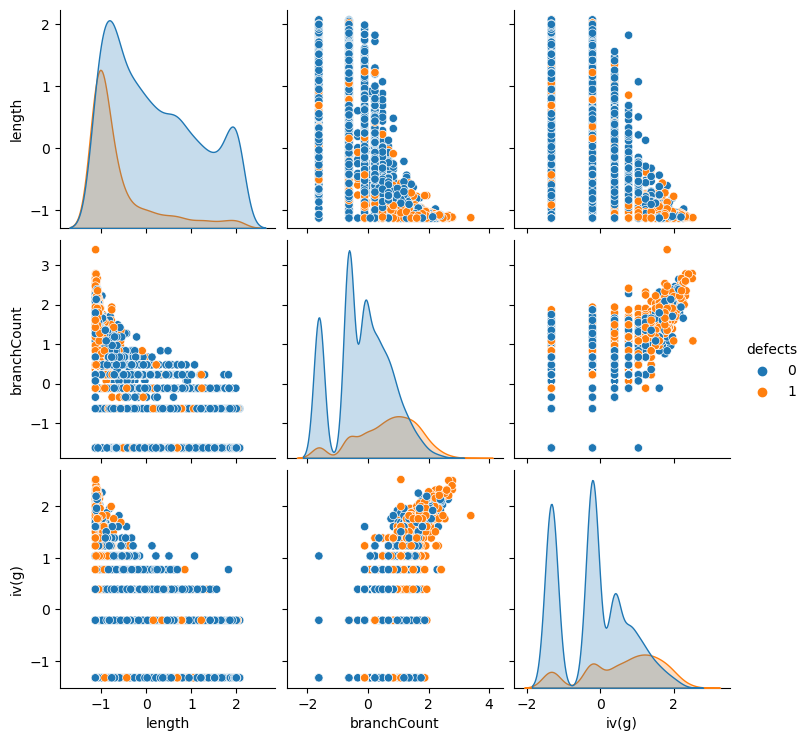

In [31]:
sns.pairplot(
    prepared_df[["length", "branchCount", "iv(g)", "defects"]].sample(5000),
    hue="defects",
)

In these pairplots, there is no obvious pattern we can take advantage of. The other pairplots are similar. 

# Creating transformation pipelines <a name="pipe"></a>

We now create several custom transformers that will allow us to easily transform our data using pipelines later.

In [32]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """adds four new features to the dataframe, outputs the new dataframe"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["propn_uniq_op"] = X["uniq_Op"] / (X["total_Op"] + 1)
        X["propn_uniq_opnd"] = X["uniq_Opnd"] / (X["total_Opnd"] + 1)
        X["length"] = X["l"] / (X["loc"] + 1)

        return X

In [33]:
class RemoveFeatures(BaseEstimator, TransformerMixin):
    """Returns the dataframe only containing three features: loc, length and line_count_diff"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cols = [
            "n",
            "v",
            "d",
            "i",
            "b",
            "t",
            "lOCode",
            "v(g)",
            "l",
            "e",
            "uniq_Op",
            "loc",
            "lOBlank",
            "total_Op",
            "uniq_Opnd",
        ]

        X = X.drop(columns=cols)
        return X

All of our data preparation steps thus far can be summarised in the following pipeline.

In [34]:
preparation_pipeline = Pipeline(
    [
        ("attribs_adder", CombinedAttributesAdder()),
        ("remove_features", RemoveFeatures()),
        ("pwr_transform", PowerTransformer()),
        ("scale", RobustScaler()),
    ]
)

We will also consider a version of the above pipeline where we add in polynomial features. 

In [35]:
preparation_pipeline_poly = Pipeline(
    [
        ("attribs_adder", CombinedAttributesAdder()),
        ("remove_features", RemoveFeatures()),
        ("add_poly", PolynomialFeatures(2)),
        ("pwr_transform", PowerTransformer()),
        ("scale", RobustScaler()),
    ]
)

# Testing models<a name="model"></a>

We now begin testing models. We will utilise three training sets: the original training set, the original training set plus polynomial features, and an oversampled training set.

In [36]:
X = preparation_pipeline.fit_transform(train_df.drop(columns=["defects"]))
X_poly = preparation_pipeline_poly.fit_transform(train_df.drop(columns=["defects"]))
y = train_df["defects"]

### Random forest on prepared data, polynomial data, and oversampled data <a name="m1"></a>

First, we will see if our data preparation changes the scores of our baseline model much, and if adding polynomial features helps. 

In [39]:
train_classifier(forest, "forest_poly", X_poly, y)
results_df = update_results(results_df, "forest_poly", include_oversampled = False)

train_classifier(forest, "forest", X, y)
train_classifier(forest, "forest_oversampled", X, y, oversampling=True)
results_df = update_results(results_df, "forest")

results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,baseline_forest,1.00000,0.77006,93.66,6.34,62.92,37.08
2,forest,0.99645,0.75042,92.91,7.09,65.23,34.77
1,forest_poly,0.99644,0.74801,92.87,7.13,65.27,34.73
3,forest_oversampled,0.99404,0.74562,86.05,13.95,51.94,48.06


Our data preparation did not improve our testing auc score, but it did reduce the extent of overfitting very slightly. Adding polynomial features did not seem to help. Each model is still overfitting the training data. Unsurpisingly, the oversampled forest predicts the minority class better than the other models, taking the percentage of true predictions from the positive class frmo 37% in the forest model without oversampling to 48% in the oversampled forest.

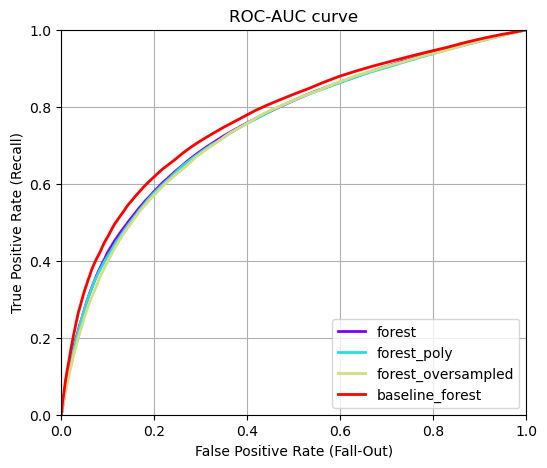

In [40]:
plot_roc_curve(['forest', 'forest_poly', 'forest_oversampled', 'baseline_forest'])

### Regularised random forest <a name="m2"></a>

Since our random forest is overfitting, we will add some regularisation using the max_depth and max_features hyperparameters. We use a randomized search to find the optimal choice of these parameters.

In [41]:
forest_params = [
    {
        "max_depth": randint(low=4, high=15),
        "max_features": randint(low=2, high=5),
        "min_samples_split": randint(low=1, high=5),
        "min_samples_leaf": randint(low=1, high=10),
        "bootstrap": [True, False],
    }
]

train_best_clf(model=forest, model_name="tuned_forest", params=forest_params, input_data = X, output_data= y)

results_df = update_results(results_df, "tuned_forest")

results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
4,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
5,tuned_forest_oversampled,0.79702,0.77530,77.97,22.03,34.98,65.02
0,baseline_forest,1.00000,0.77006,93.66,6.34,62.92,37.08
1,forest,0.99645,0.75042,92.91,7.09,65.23,34.77
2,forest_poly,0.99644,0.74801,92.87,7.13,65.27,34.73
3,forest_oversampled,0.99404,0.74562,86.05,13.95,51.94,48.06


In [71]:
forest_best = RandomForestClassifier(**get_params(model_name = "tuned_forest", input_data =X, output_data=y)['best_params'])
forest_best.fit(X, y)

feature_importance = forest_best.feature_importances_.round(4)

sorted(zip(feature_importance, preparation_pipeline['pwr_transform'].get_feature_names_out()), reverse=True)

[(0.2695, 'length'),
 (0.2001, 'propn_uniq_op'),
 (0.1403, 'branchCount'),
 (0.1352, 'iv(g)'),
 (0.1261, 'total_Opnd'),
 (0.0636, 'propn_uniq_opnd'),
 (0.0257, 'lOComment'),
 (0.0253, 'ev(g)'),
 (0.0088, 'locCodeAndComment'),
 (0.0053, 'zero_vals')]

We have reduced the extent of overfitting using regularisation. The two most important featuers are length and propn_uniq_op.

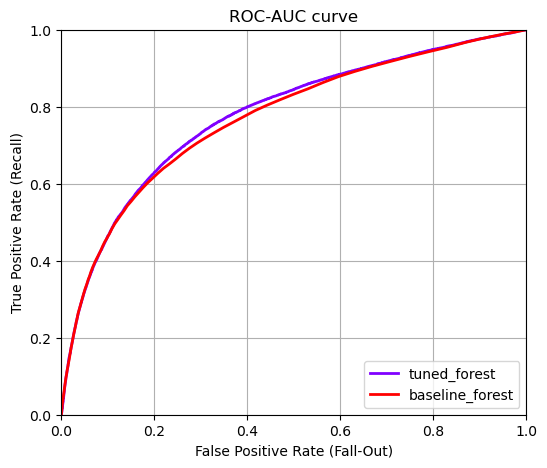

In [42]:
plot_roc_curve(['tuned_forest','baseline_forest'])

### Extra-Tree Classifier<a name="m3"></a>

An extra-tree classifier uses random thresholds in each tree node. This should help us reduce the overfitting we've observed. We first fit an extra-trees forest with some regularisation, then do this again for the oversampled dataset.

In [44]:
ext_forest = ExtraTreesClassifier(random_state=42)

extra_forest_params = [
    {
        "max_depth": randint(low=4, high=15),
        "max_features": list(range(2, 20)) + ["sqrt", "log2"],
        "min_samples_split": randint(low=2, high=6),
        "min_samples_leaf": randint(low=1, high=15),
        "bootstrap": [True, False],
    }
]

train_best_clf(input_data = X, output_data = y, model=ext_forest, model_name="ext_forest", params=extra_forest_params)

results_df = update_results(results_df, "ext_forest")

results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
6,ext_forest,0.81207,0.77718,94.34,5.66,65.56,34.44
7,ext_forest_oversampled,0.79058,0.77581,75.63,24.37,32.32,67.68
1,tuned_forest_oversampled,0.79702,0.77530,77.97,22.03,34.98,65.02
2,baseline_forest,1.00000,0.77006,93.66,6.34,62.92,37.08
3,forest,0.99645,0.75042,92.91,7.09,65.23,34.77
4,forest_poly,0.99644,0.74801,92.87,7.13,65.27,34.73
5,forest_oversampled,0.99404,0.74562,86.05,13.95,51.94,48.06


As expected, the randomness in the extra-forest has reduced the extent of overfitting.

### Logistic Regression <a name="m4"></a>

Let's now investigate a logistic regression model, and logistic regression with regularisation, and finally logistic regression with regularsation on the oversampled data.

In [45]:
log_reg = LogisticRegression(random_state=42)

log_reg_params = [
    {
        "C": [0.02, 0.03, 0.04, 0.05, 0.1, 0.15],
    }
]

train_best_clf(input_data = X, output_data = y, model=log_reg, model_name="log_reg", params=log_reg_params)

results_df = update_results(results_df, "log_reg")

results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
1,ext_forest,0.81207,0.77718,94.34,5.66,65.56,34.44
2,ext_forest_oversampled,0.79058,0.77581,75.63,24.37,32.32,67.68
3,tuned_forest_oversampled,0.79702,0.77530,77.97,22.03,34.98,65.02
9,log_reg_oversampled,0.77023,0.77007,72.36,27.64,29.83,70.17
4,baseline_forest,1.00000,0.77006,93.66,6.34,62.92,37.08
8,log_reg,0.76991,0.76975,95.57,4.43,71.03,28.97
5,forest,0.99645,0.75042,92.91,7.09,65.23,34.77
6,forest_poly,0.99644,0.74801,92.87,7.13,65.27,34.73
7,forest_oversampled,0.99404,0.74562,86.05,13.95,51.94,48.06


Logistic regression has the lowest training_auc score so far, so is overfitting the least.

### Histogram-based gradient boosted forest <a name="m5"></a>

In this section, we will see AdaBoost helps detect the defective class. AdaBoost works by iteravely training a model to try to correct the errors from the previous model.

In [46]:
hist_boost = HistGradientBoostingClassifier(random_state=30)

hist_boost_params = [
    {
        "max_iter": randint(low=50, high=100),
        "max_leaf_nodes": randint(low=10, high=31),
        "max_depth": randint(low=5, high=100),
        "l2_regularization": [None, 1.2],
        "max_bins": randint(low=100, high=255),
        "class_weight": ["balanced", None],
    }
]


train_best_clf(input_data = X, output_data = y,model=hist_boost, model_name="hist_boost", params=hist_boost_params)

results_df = update_results(results_df, "hist_boost")

results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
10,hist_boost,0.78809,0.77817,94.30,5.70,65.45,34.55
0,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
1,ext_forest,0.81207,0.77718,94.34,5.66,65.56,34.44
2,ext_forest_oversampled,0.79058,0.77581,75.63,24.37,32.32,67.68
3,tuned_forest_oversampled,0.79702,0.77530,77.97,22.03,34.98,65.02
11,hist_boost_oversampled,0.77937,0.77512,78.63,21.37,35.88,64.12
4,log_reg_oversampled,0.77023,0.77007,72.36,27.64,29.83,70.17
5,baseline_forest,1.00000,0.77006,93.66,6.34,62.92,37.08
6,log_reg,0.76991,0.76975,95.57,4.43,71.03,28.97
7,forest,0.99645,0.75042,92.91,7.09,65.23,34.77


Hist-gradient boosting is performing the best so far

### Gradient boosted classifier <a name="m6"></a>

In [47]:
xgb_clf = XGBClassifier(random_state=42)

xgb_params = [
    {
        "n_estimators": randint(low=50, high=200),
        "max_depth": randint(low=5, high=25),
        "max_leaves": randint(low=5, high=100),
    }
]

train_best_clf(input_data = X, output_data = y, model=xgb_clf, model_name="xgboost", params=xgb_params)

results_df = update_results(results_df, "xgboost")


results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,hist_boost,0.78809,0.77817,94.30,5.70,65.45,34.55
1,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
2,ext_forest,0.81207,0.77718,94.34,5.66,65.56,34.44
3,ext_forest_oversampled,0.79058,0.77581,75.63,24.37,32.32,67.68
4,tuned_forest_oversampled,0.79702,0.77530,77.97,22.03,34.98,65.02
5,hist_boost_oversampled,0.77937,0.77512,78.63,21.37,35.88,64.12
12,xgboost,0.80352,0.77495,94.05,5.95,65.34,34.66
6,log_reg_oversampled,0.77023,0.77007,72.36,27.64,29.83,70.17
7,baseline_forest,1.00000,0.77006,93.66,6.34,62.92,37.08
8,log_reg,0.76991,0.76975,95.57,4.43,71.03,28.97


Observations:
- The best three models do not use oversampling, overfit the training data quite a lot, and make similar errors: namely, they predict the majority class very well, but perform poorly on the minority class (only predicting about 34% of the minority class correctly)
- The next three best models have a very similar testing score as the top three models, but reduce the extent of overfitting and predict the minority class better.
- Even our best model, hist_boost, has only improved the testing score of the baseline model slightly (see roc curve below).

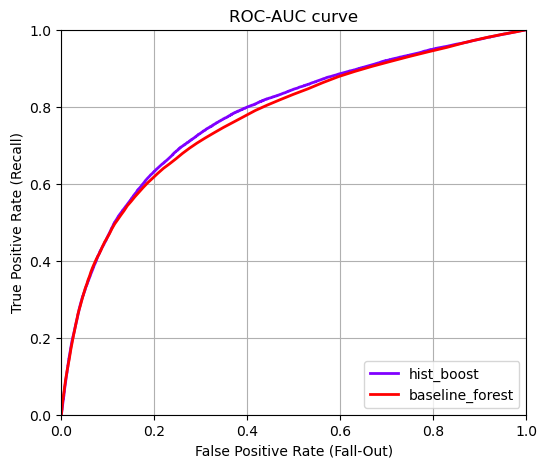

In [48]:
plot_roc_curve(['hist_boost','baseline_forest'])

# Final Ensembles <a name="ensemble"></a>

In this section we combine a few of our best models into a stacked ensemble. To begin we initialise our best models.

In [61]:
hist_boost_params = get_params(input_data = X, output_data = y, model_name = "hist_boost")
ext_forest_params = get_params(input_data = X, output_data = y,model_name = "ext_forest")
forest_params = get_params(input_data = X, output_data = y,model_name = "forest")
xgb_params = get_params(input_data = X, output_data = y,model_name = "xgboost")
log_params = get_params(input_data = X, output_data = y,model_name = "log_reg")

hist_boost = HistGradientBoostingClassifier(
    **hist_boost_params["best_params"], random_state=31
)
hist_boost_oversampled = oversampled_version(
    HistGradientBoostingClassifier(
        **hist_boost_params["best_oversampled_params"], random_state=30
    ),
    "hist_boost",
)

ext_forest = ExtraTreesClassifier(**ext_forest_params["best_params"], random_state=42)
ext_forest_oversampled = oversampled_version(
    ExtraTreesClassifier(
        **ext_forest_params["best_oversampled_params"], random_state=43
    ),
    "ext_forest",
)

tuned_forest = RandomForestClassifier(**forest_params["best_params"], random_state=4)
tuned_forest_oversampled = oversampled_version(
    RandomForestClassifier(**forest_params["best_oversampled_params"], random_state=5),
    "forest",
)

xgboost = XGBClassifier(**xgb_params["best_params"], random_state=7)
xgboost_oversampled = oversampled_version(
    XGBClassifier(**xgb_params["best_oversampled_params"], random_state=41), "xgb"
)

log_reg = LogisticRegression(**log_params["best_params"], random_state=88)
log_reg_oversampled = oversampled_version(
    LogisticRegression(**log_params["best_oversampled_params"], random_state=87),
    "log_reg",
)

## Stacking classifier

In [62]:
stack_clf = StackingClassifier(
    estimators=[
        ("clf1", hist_boost),
        ("clf2", hist_boost_oversampled),
        ("clf3", ext_forest),
        ("clf4", ext_forest_oversampled),
        ("clf5", tuned_forest),
        ("clf6", tuned_forest_oversampled),
        ("clf7", xgboost),
        ("clf8", xgboost_oversampled),
        ("clf9", log_reg),
        ("clf10", log_reg_oversampled),
    ],
    cv=5,
)

In [63]:
train_classifier(stack_clf, "stacked_clf_smaller", X, y)

In [64]:
results_df = update_results(
    results_df, "stacked_clf", include_oversampled=False
)
results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,hist_boost,0.78809,0.77817,94.30,5.70,65.45,34.55
14,stacked_clf,0.79531,0.77791,93.81,6.19,63.54,36.46
1,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
2,ext_forest,0.81207,0.77718,94.34,5.66,65.56,34.44
3,ext_forest_oversampled,0.79058,0.77581,75.63,24.37,32.32,67.68
4,tuned_forest_oversampled,0.79702,0.77530,77.97,22.03,34.98,65.02
5,hist_boost_oversampled,0.77937,0.77512,78.63,21.37,35.88,64.12
6,xgboost,0.80352,0.77495,94.05,5.95,65.34,34.66
7,log_reg_oversampled,0.77023,0.77007,72.36,27.64,29.83,70.17
8,baseline_forest,1.00000,0.77006,93.66,6.34,62.92,37.08


In [65]:
stack_clf_fewer_estimators = StackingClassifier(
    estimators=[
        ("clf1", hist_boost),
        ("clf2", hist_boost_oversampled),
        ("clf3", ext_forest),
        ("clf4", ext_forest_oversampled),
        ("clf5", tuned_forest),
        ("clf6", tuned_forest_oversampled),
    ],
    cv=5,
)

In [67]:
train_classifier(stack_clf_fewer_estimators, "stacked_clf_fewer", X, y)
results_df = update_results(results_df, "stacked_clf_fewer", include_oversampled=False)
results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,hist_boost,0.78809,0.77817,94.30,5.70,65.45,34.55
15,stacked_clf_fewer,0.79490,0.77810,93.78,6.22,63.63,36.37
1,stacked_clf,0.79531,0.77791,93.81,6.19,63.54,36.46
2,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
3,ext_forest,0.81207,0.77718,94.34,5.66,65.56,34.44
4,ext_forest_oversampled,0.79058,0.77581,75.63,24.37,32.32,67.68
5,tuned_forest_oversampled,0.79702,0.77530,77.97,22.03,34.98,65.02
6,hist_boost_oversampled,0.77937,0.77512,78.63,21.37,35.88,64.12
7,xgboost,0.80352,0.77495,94.05,5.95,65.34,34.66
8,log_reg_oversampled,0.77023,0.77007,72.36,27.64,29.83,70.17


- The stacking classifier is now our third best model, but only by a small amount. The number of estimators in the stacking classifier might be adding additional noise which results in a model that is worse than one of the base estimators, the histogram-based gradient estimator. 
- The stacking classifier with fewer features is now our second best model, with a very similar roc-auc validation score to the best model. 
- Our stacking ensembles have not improved our models enough to justify their increased complexity, so they will not be used in our final model.

## Voting ensemble

For our voting ensemble, we will compare different choices of estimators that will go in the ensemble.

In [72]:
estimator_choices = [
    [
        ("hist_boost", hist_boost),
        ("hist_boost_oversampled", hist_boost_oversampled),
        ("ext_forest", ext_forest),
        ("ext_forest_oversampled", ext_forest_oversampled),
        ("tuned_forest", tuned_forest)
    ],
    [("hist_boost", hist_boost), ("ext_forest", ext_forest)],
    [("hist_boost", hist_boost), ("ext_forest", ext_forest), ("tuned_forest", tuned_forest)],
    [
        ("hist_boost", hist_boost),
        ("hist_boost_oversampled", hist_boost_oversampled),
        ("ext_forest", ext_forest),
        ("ext_forest_oversampled", ext_forest_oversampled),
        ("tuned_forest", tuned_forest),
        ("tuned_forest_oversampled", tuned_forest_oversampled),
        ("clf7", xgboost),
        ("clf8_oversampled", xgboost_oversampled),
        ("clf9", log_reg)
    ],
    [
        ("hist_boost", hist_boost),
        ("ext_forest", ext_forest),
        ("tuned_forest_oversampled", tuned_forest_oversampled),
        ("tuned_forest", tuned_forest)
    ],
     [
        ("hist_boost_oversampled", hist_boost_oversampled),
        ("ext_forest", ext_forest_oversampled),
        ("tuned_forest", tuned_forest_oversampled)
    ]
]

In [74]:
for i in range(0, 6):
    voting_clf = VotingClassifier(estimators=estimator_choices[i], voting="soft")
    train_classifier(voting_clf, f"voting_{i}", X, y)
    results_df = update_results(results_df, f"voting_{i}", include_oversampled=False)

results_df

,model,training_auc,testing_auc,true_neg,false_pos,false_neg,true_pos
0,voting_1,0.80210,0.77852,94.40,5.60,65.55,34.45
1,voting_2,0.80586,0.77846,94.42,5.58,65.55,34.45
2,voting_0,0.79771,0.77825,89.89,10.11,53.39,46.61
3,hist_boost,0.78809,0.77817,94.30,5.70,65.45,34.55
4,voting_4,0.79954,0.77812,91.74,8.26,57.78,42.22
5,stacked_clf_fewer,0.79490,0.77810,93.78,6.22,63.63,36.37
6,stacked_clf,0.79531,0.77791,93.81,6.19,63.54,36.46
7,voting_3,0.79666,0.77774,89.96,10.04,53.44,46.56
8,tuned_forest,0.81106,0.77743,94.35,5.65,65.54,34.46
9,ext_forest,0.81207,0.77718,94.34,5.66,65.56,34.44


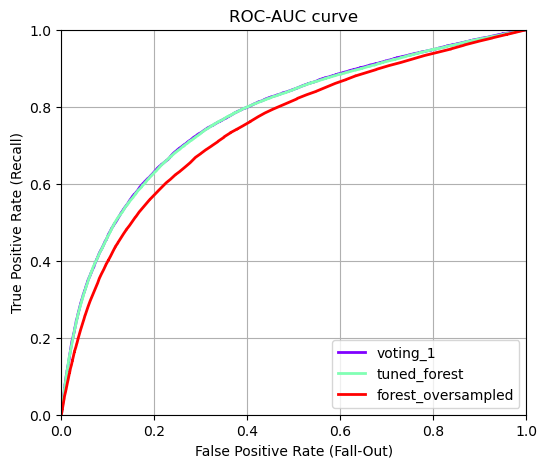

In [80]:
plot_roc_curve(['voting_1', 'tuned_forest', 'forest_oversampled'])

- The model voting_1 has the best roc curve, but it is only marginally better than others and has a very high training score. In fact, it performs very similar to the tuned forest and has much more complexity than the tuned forest.
- We will tune the weights for the best voting classifier to see how that changes things.

In [83]:
weights = [[1, 1], [2, 1], [1,2], [.5, 1.5], [1.5, .5]]
param_grid = [{"weights": weights}]
vote_clf_tuned = VotingClassifier(estimators=estimator_choices[1], voting="soft")
rnd_search = GridSearchCV(
    vote_clf_tuned, param_grid=param_grid, cv=3, verbose=4, scoring="roc_auc"
)

rnd_search.fit(X, y)

rnd_search.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ....................weights=[1, 1];, score=0.777 total time=   3.0s
[CV 2/3] END ....................weights=[1, 1];, score=0.780 total time=   3.3s
[CV 3/3] END ....................weights=[1, 1];, score=0.777 total time=   3.0s
[CV 1/3] END ....................weights=[2, 1];, score=0.777 total time=   3.0s
[CV 2/3] END ....................weights=[2, 1];, score=0.780 total time=   3.0s
[CV 3/3] END ....................weights=[2, 1];, score=0.777 total time=   3.0s
[CV 1/3] END ....................weights=[1, 2];, score=0.777 total time=   3.0s
[CV 2/3] END ....................weights=[1, 2];, score=0.780 total time=   3.0s
[CV 3/3] END ....................weights=[1, 2];, score=0.777 total time=   3.0s
[CV 1/3] END ................weights=[0.5, 1.5];, score=0.777 total time=   3.0s
[CV 2/3] END ................weights=[0.5, 1.5];, score=0.780 total time=   3.0s
[CV 3/3] END ................weights=[0.5, 1.5];,

{'weights': [1, 1]}

Based on the above, we will not change the weights of the voting classifier. If more computation time was allowed, we could tune hyperparameters more carefully.

# making prediction

In [95]:
model = VotingClassifier(
    estimators=estimator_choices[1], voting="soft",
)
X_test = preparation_pipeline.fit_transform(test_df)

In [96]:
model.fit(X, y)

predictions = model.predict_proba(X_test)

submission = pd.DataFrame(predictions, index=test_df.id)

submission_final = pd.DataFrame(submission.iloc[:, 1]).rename(columns={1: "Defects"})

submission_final

submission_final.to_csv("final_model.csv")

In [97]:
submission_final

,Defects
id,
101763,0.252875
101764,0.418346
101765,0.705814
101766,0.212283
101767,0.085304
...,...
169600,0.164628
169601,0.078064
169602,0.086983
